## load the dataset and create the final using dataset with attribute "Quadrant". 

In [1]:
import sys
print(sys.executable)


import os
import pandas as pd
from pathlib import Path

train_folder_Q1 = Path("projectdata/images/100_stratified4fold_1000per_seed3888/Q1")
train_folder_Q2= Path("projectdata/images/100_stratified4fold_1000per_seed3888/Q2")
train_folder_Q3 = Path("projectdata/images/100_stratified4fold_1000per_seed3888/Q3")
train_folder_Q4 = Path("projectdata/images/100_stratified4fold_1000per_seed3888/Q4")

test_folder_Q1 = Path("projectdata/images/uncentred_ternary_100_stratified4fold_1000per_seed3888/Q1")
test_folder_Q2 = Path("projectdata/images/uncentred_ternary_100_stratified4fold_1000per_seed3888/Q2")
test_folder_Q3 = Path("projectdata/images/uncentred_ternary_100_stratified4fold_1000per_seed3888/Q3")
test_folder_Q4 = Path("projectdata/images/uncentred_ternary_100_stratified4fold_1000per_seed3888/Q4")

cell_types = ["Empty", "Non-Tumor", "Tumor"]
# multiclass_folder = Path("projectdata/images/uncentred_multiclass_224_stratified4fold_1000per_seed3888")


/Users/homeyellow/anaconda3/envs/tfenv/bin/python


In [2]:
# Prepare a list for all records
records = []
  
# Traverse folders
def get_records(quadrant, path, test):
    records = []
    
    for folder_name in os.listdir(path):
        folder_path = Path(f"{path}/{folder_name}")
        if folder_path.is_dir():
            
            if folder_name not in cell_types:
                print(f"Warning: Folder {folder_name} not found in cell types. Skipping.")
                continue
    
            # Loop through images
            for file_name in os.listdir(folder_path):
                if file_name.endswith((".png", ".jpg", ".jpeg")):
                    full_path = f"{folder_path}/{file_name}"
                    parts = file_name.replace(".png", "").split("_")

                    if test:
                        x = int(parts[1])
                        y = int(parts[2])
                    else:
                        x = None
                        y = None
    
                    records.append({
                        "Quadrant": quadrant,
                        "File Name": file_name,
                        "Path": str(full_path),
                        "Category Type": folder_name,
                        "x":x,
                        "y":y
                    })
    return records

train_records_q1 = get_records("Q1", train_folder_Q1, False)
train_records_q2 = get_records("Q2", train_folder_Q2, False)
train_records_q3 = get_records("Q3", train_folder_Q3, False)
train_records_q4 = get_records("Q4", train_folder_Q4, False)

train_df_q1 = pd.DataFrame(train_records_q1)
train_df_q2 = pd.DataFrame(train_records_q2)
train_df_q3 = pd.DataFrame(train_records_q3)
train_df_q4 = pd.DataFrame(train_records_q4)

test_records_q1 = get_records("Q1", test_folder_Q1, True)
test_records_q2 = get_records("Q2", test_folder_Q2, True)
test_records_q3 = get_records("Q3", test_folder_Q3, True)
test_records_q4 = get_records("Q4", test_folder_Q4, True)

test_df_q1 = pd.DataFrame(test_records_q1)
test_df_q2 = pd.DataFrame(test_records_q2)
test_df_q3 = pd.DataFrame(test_records_q3)
test_df_q4 = pd.DataFrame(test_records_q4)

# # Create DataFrame
# df_image_raw = pd.DataFrame(records)
# df_image_raw.head()

# df_image = df_image_raw[df_image_raw['Category Type'] != "Unlabeled"].reset_index(drop=True)


In [3]:
train_df_final = pd.concat([train_df_q1, train_df_q2, train_df_q3, train_df_q4])
test_df_final = pd.concat([test_df_q1, test_df_q2, test_df_q3, test_df_q4])
# df_final.to_csv("used_dataset_bindy.csv", index=False)
df_g_tr = train_df_final.groupby("Category Type")["File Name"].count()
df_g_te = test_df_final.groupby("Category Type")["File Name"].count()
df_g2_tr = train_df_final.groupby("Quadrant")["Category Type"].count()
df_g2_te = test_df_final.groupby("Quadrant")["Category Type"].count()
# df_g_tr
# df_g_te
# test_df_final

In [4]:
df_g_tr

Category Type
Empty         400
Non-Tumor    2012
Tumor        1834
Name: File Name, dtype: int64

In [5]:
df_g2_tr

Quadrant
Q1    1050
Q2     990
Q3    1103
Q4    1103
Name: Category Type, dtype: int64

In [6]:
df_g_te

Category Type
Empty         512
Non-Tumor    2000
Tumor        2000
Name: File Name, dtype: int64

In [7]:
df_g2_te

Quadrant
Q1    1128
Q2    1128
Q3    1128
Q4    1128
Name: Category Type, dtype: int64

## Implementing the VGG16 model

In [8]:
import sys
print(sys.executable)
import sys
import tensorflow as tf

print("Interpreter path:", sys.executable)
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)



import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set random seeds
np.random.seed(3888)
tf.random.set_seed(3888)

# # Load your balanced dataset
# df = df_final

# # Print basic info
# print(df['Category Type'].value_counts())
# print(df['Quadrant'].value_counts())

label_map = {'Tumor': 0, 'Non-Tumor': 1, 'Empty': 2}

train_df_final['label'] = train_df_final['Category Type'].map(label_map)
train_df_final['label'] = train_df_final['label'].astype(str)

test_df_final['label'] = test_df_final['Category Type'].map(label_map)
test_df_final['label'] = test_df_final['label'].astype(str)

def build_vgg16_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 classes

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


/Users/homeyellow/anaconda3/envs/tfenv/bin/python
Interpreter path: /Users/homeyellow/anaconda3/envs/tfenv/bin/python
TensorFlow version: 2.16.2
Keras version: 3.9.2


In [9]:
train_df = train_df_final[train_df_final["Quadrant"] == "Q1"]
train_df

,Quadrant,File Name,Path,Category Type,x,y,label
0,Q1,topleft_9_0.png,projectdata/images/100_stratified4fold_1000per...,Empty,None,None,2
1,Q1,topleft_1_9.png,projectdata/images/100_stratified4fold_1000per...,Empty,None,None,2
2,Q1,topleft_1_8.png,projectdata/images/100_stratified4fold_1000per...,Empty,None,None,2
3,Q1,topleft_9_1.png,projectdata/images/100_stratified4fold_1000per...,Empty,None,None,2
4,Q1,topleft_9_3.png,projectdata/images/100_stratified4fold_1000per...,Empty,None,None,2
...,...,...,...,...,...,...,...
1045,Q1,cell_33431_100.png,projectdata/images/100_stratified4fold_1000per...,Non-Tumor,None,None,1
1046,Q1,cell_98512_100.png,projectdata/images/100_stratified4fold_1000per...,Non-Tumor,None,None,1
1047,Q1,cell_97789_100.png,projectdata/images/100_stratified4fold_1000per...,Non-Tumor,None,None,1
1048,Q1,cell_61222_100.png,projectdata/images/100_stratified4fold_1000per...,Non-Tumor,None,None,1


Starting Fold: Test on Q1
Found 1050 validated image filenames belonging to 3 classes.
Found 3196 validated image filenames belonging to 3 classes.
Found 1128 validated image filenames belonging to 3 classes.


2025-05-19 03:38:37.252068: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-19 03:38:37.252089: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-19 03:38:37.252092: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-19 03:38:37.252108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-19 03:38:37.252120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/homeyellow/anaconda3/envs/tfenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super

Epoch 1/20


2025-05-19 03:38:38.543844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 532ms/step - accuracy: 0.3581 - loss: 1.3060 - val_accuracy: 0.5673 - val_loss: 0.8517
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 508ms/step - accuracy: 0.4762 - loss: 0.9638 - val_accuracy: 0.6436 - val_loss: 0.7551
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 507ms/step - accuracy: 0.5480 - loss: 0.8568 - val_accuracy: 0.7034 - val_loss: 0.6787
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 506ms/step - accuracy: 0.5954 - loss: 0.7584 - val_accuracy: 0.7857 - val_loss: 0.6163
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 508ms/step - accuracy: 0.6677 - loss: 0.6864 - val_accuracy: 0.7819 - val_loss: 0.5746
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 508ms/step - accuracy: 0.7060 - loss: 0.6215 - val_accuracy: 0.7907 - val_loss: 0.5442
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 508ms/step - accuracy: 0.6862 - loss: 0.6372 - val_accuracy: 0.7866 - val_loss: 0.5298
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 509ms/step - accuracy: 0.7002 - loss: 0.6001 - val_accuracy: 0.787

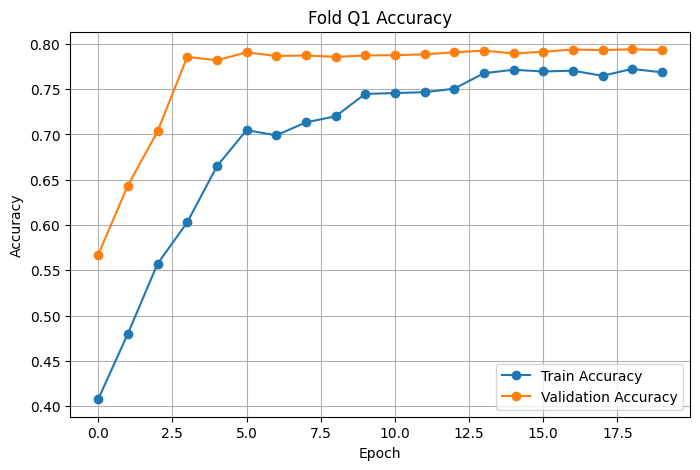

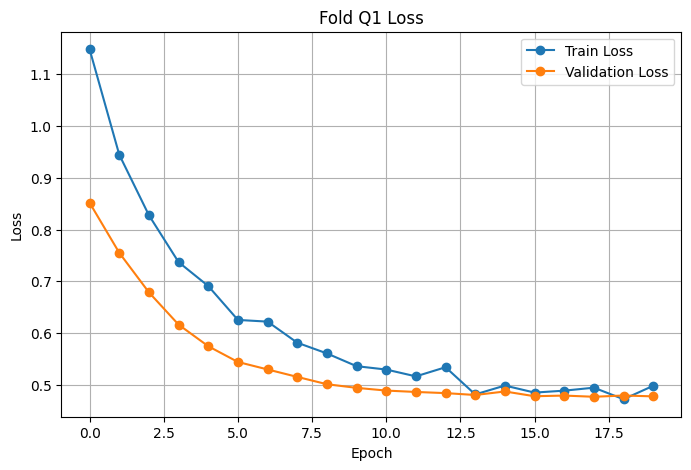

Saved model: vgg16_fold_Q1.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step


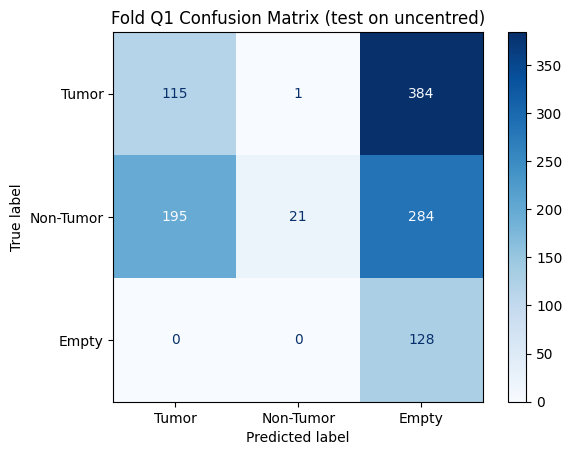

Fold Q1 Accuracy: 0.2340, F1 Score: 0.2138
Classification Report for Fold Q1:
              precision    recall  f1-score   support

       Tumor     0.3710    0.2300    0.2840       500
   Non-Tumor     0.9545    0.0420    0.0805       500
       Empty     0.1608    1.0000    0.2771       128

    accuracy                         0.2340      1128
   macro avg     0.4954    0.4240    0.2138      1128
weighted avg     0.6058    0.2340    0.1930      1128

Starting Fold: Test on Q2
Found 990 validated image filenames belonging to 3 classes.
Found 3256 validated image filenames belonging to 3 classes.
Found 1128 validated image filenames belonging to 3 classes.


/Users/homeyellow/anaconda3/envs/tfenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 566ms/step - accuracy: 0.4951 - loss: 1.0328 - val_accuracy: 0.5719 - val_loss: 0.8012
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 546ms/step - accuracy: 0.5599 - loss: 0.9114 - val_accuracy: 0.6161 - val_loss: 0.7102
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 548ms/step - accuracy: 0.6303 - loss: 0.7756 - val_accuracy: 0.6628 - val_loss: 0.6564
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 544ms/step - accuracy: 0.6448 - loss: 0.7011 - val_accuracy: 0.7706 - val_loss: 0.5811
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 539ms/step - accuracy: 0.6917 - loss: 0.6474 - val_accuracy: 0.7715 - val_loss: 0.5511
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 537ms/step - accuracy: 0.7163 - loss: 0.6118 - val_accuracy: 0.7684 - val_loss: 0.5327
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 542ms/step - accuracy: 0.7037 - loss: 0.6139 - val_accuracy: 0.7715 - val_loss: 0.5185
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 538ms/step - accuracy: 0.7520 - loss: 0.5332 - val_accu

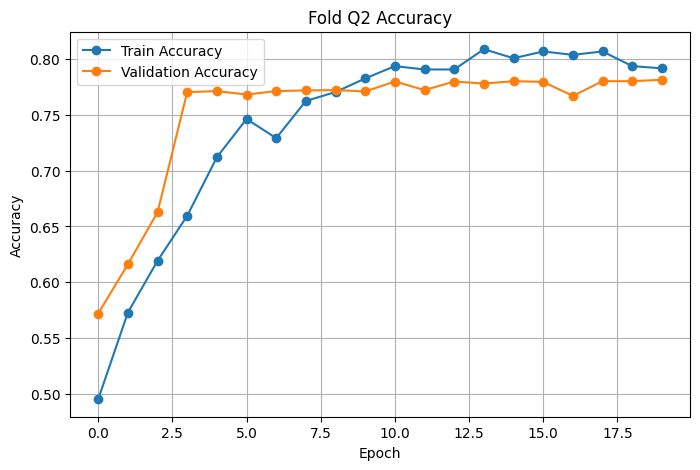

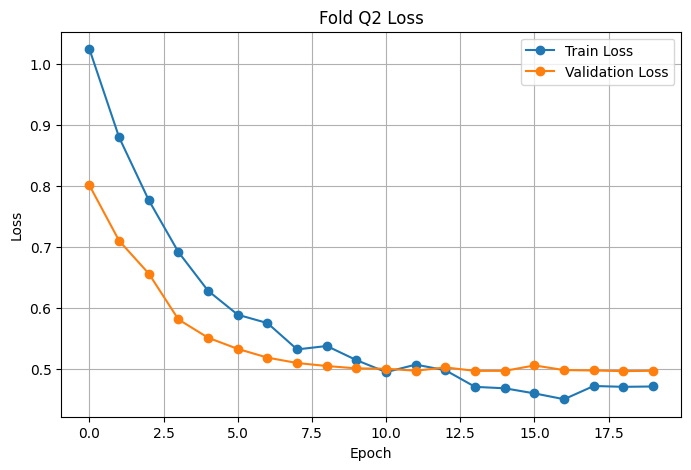

Saved model: vgg16_fold_Q2.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step


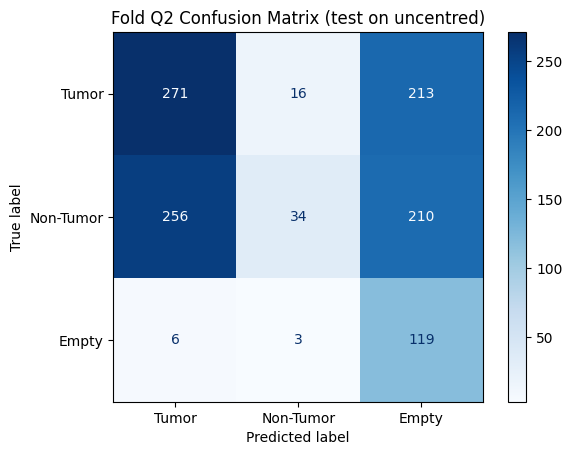

Fold Q2 Accuracy: 0.3759, F1 Score: 0.3343
Classification Report for Fold Q2:
              precision    recall  f1-score   support

       Tumor     0.5084    0.5420    0.5247       500
   Non-Tumor     0.6415    0.0680    0.1230       500
       Empty     0.2196    0.9297    0.3552       128

    accuracy                         0.3759      1128
   macro avg     0.4565    0.5132    0.3343      1128
weighted avg     0.5346    0.3759    0.3274      1128

Starting Fold: Test on Q3
Found 1103 validated image filenames belonging to 3 classes.
Found 3143 validated image filenames belonging to 3 classes.
Found 1128 validated image filenames belonging to 3 classes.


/Users/homeyellow/anaconda3/envs/tfenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 496ms/step - accuracy: 0.4653 - loss: 1.0443 - val_accuracy: 0.6532 - val_loss: 0.7880
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 479ms/step - accuracy: 0.5340 - loss: 0.8573 - val_accuracy: 0.6828 - val_loss: 0.6955
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 483ms/step - accuracy: 0.5546 - loss: 0.8260 - val_accuracy: 0.7757 - val_loss: 0.6225
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 481ms/step - accuracy: 0.6420 - loss: 0.7137 - val_accuracy: 0.7722 - val_loss: 0.5758
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 483ms/step - accuracy: 0.6494 - loss: 0.6758 - val_accuracy: 0.7801 - val_loss: 0.5400
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 481ms/step - accuracy: 0.6595 - loss: 0.6630 - val_accuracy: 0.7757 - val_loss: 0.5205
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 481ms/step - accuracy: 0.7023 - loss: 0.6256 - val_accuracy: 0.7709 - val_loss: 0.5114
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 474ms/step - accuracy: 0.6971 - loss: 0.6100 - val_accu

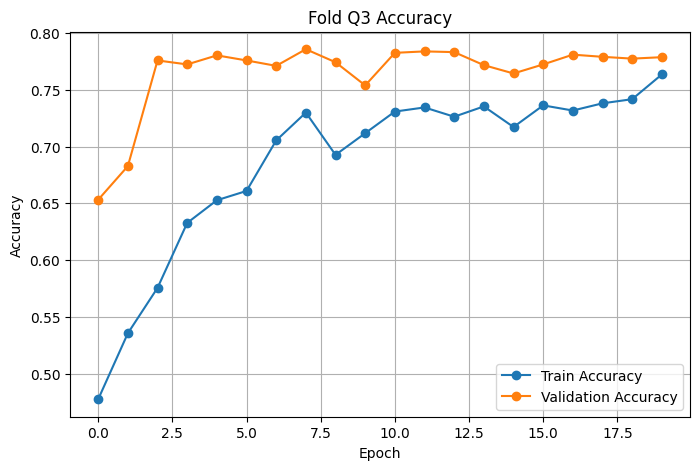

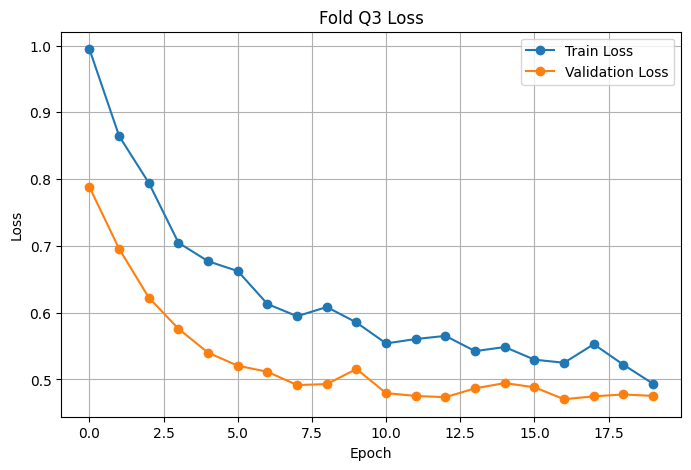

Saved model: vgg16_fold_Q3.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step


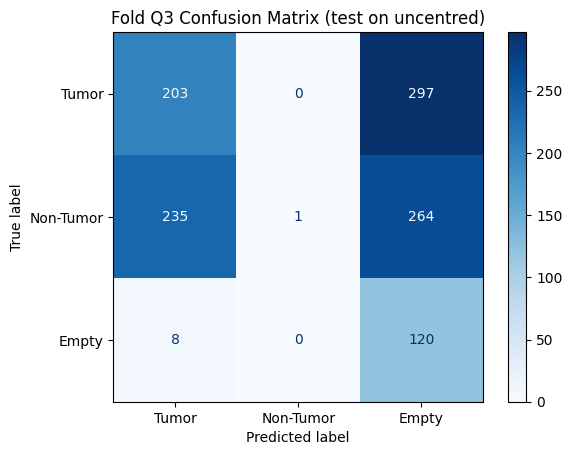

Fold Q3 Accuracy: 0.2872, F1 Score: 0.2433
Classification Report for Fold Q3:
              precision    recall  f1-score   support

       Tumor     0.4552    0.4060    0.4292       500
   Non-Tumor     1.0000    0.0020    0.0040       500
       Empty     0.1762    0.9375    0.2967       128

    accuracy                         0.2872      1128
   macro avg     0.5438    0.4485    0.2433      1128
weighted avg     0.6650    0.2872    0.2257      1128

Starting Fold: Test on Q4
Found 1103 validated image filenames belonging to 3 classes.
Found 3143 validated image filenames belonging to 3 classes.
Found 1128 validated image filenames belonging to 3 classes.


/Users/homeyellow/anaconda3/envs/tfenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 488ms/step - accuracy: 0.3749 - loss: 1.2096 - val_accuracy: 0.6548 - val_loss: 0.8198
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 480ms/step - accuracy: 0.5441 - loss: 0.8718 - val_accuracy: 0.6666 - val_loss: 0.7431
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 482ms/step - accuracy: 0.5446 - loss: 0.8632 - val_accuracy: 0.6850 - val_loss: 0.6744
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 479ms/step - accuracy: 0.5914 - loss: 0.7966 - val_accuracy: 0.6936 - val_loss: 0.6208
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 479ms/step - accuracy: 0.6443 - loss: 0.7150 - val_accuracy: 0.7502 - val_loss: 0.6164
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 480ms/step - accuracy: 0.6843 - loss: 0.6519 - val_accuracy: 0.7448 - val_loss: 0.6074
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 473ms/step - accuracy: 0.6834 - loss: 0.6618 - val_accuracy: 0.7569 - val_loss: 0.5863
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 477ms/step - accuracy: 0.6823 - loss: 0.6817 - val_accu

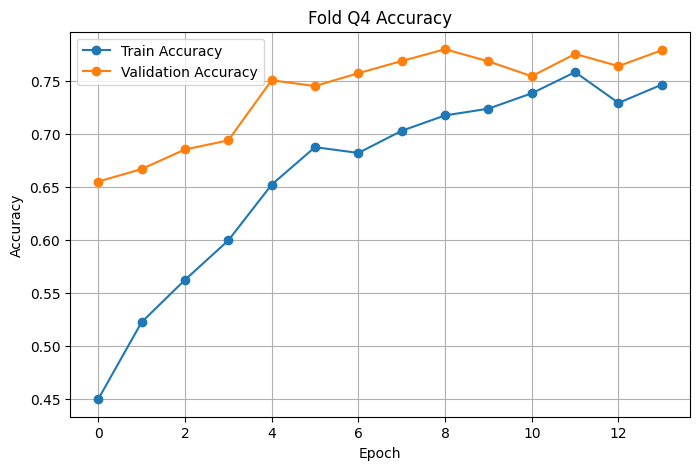

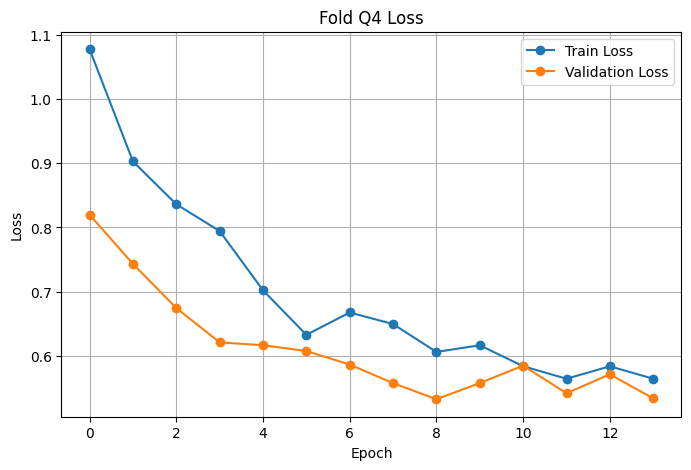

Saved model: vgg16_fold_Q4.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step


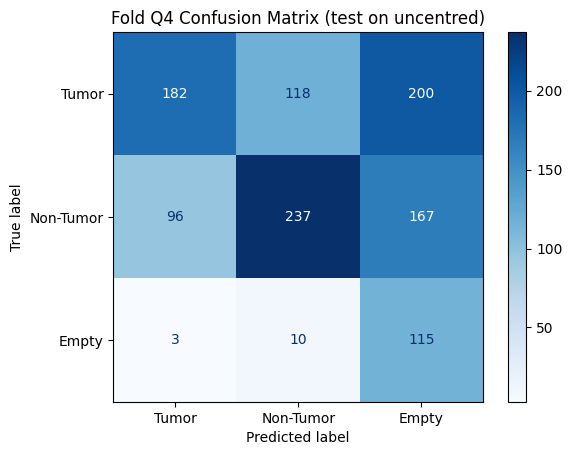

Fold Q4 Accuracy: 0.4734, F1 Score: 0.4637
Classification Report for Fold Q4:
              precision    recall  f1-score   support

       Tumor     0.6477    0.3640    0.4661       500
   Non-Tumor     0.6493    0.4740    0.5480       500
       Empty     0.2386    0.8984    0.3770       128

    accuracy                         0.4734      1128
   macro avg     0.5119    0.5788    0.4637      1128
weighted avg     0.6020    0.4734    0.4923      1128

Average 4-Fold Test Accuracy: 0.3426
Average 4-Fold Test f1: 0.3138


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Set random seeds
np.random.seed(3888)
tf.random.set_seed(3888)

# Prepare ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

quadrants = ["Q1", "Q2", "Q3", "Q4"]

# Store results
fold_accuracies = []
fold_f1_scores = []
fold_reports = []
models = {}

for quadrant in quadrants:
    print(f"Starting Fold: Test on {quadrant}")

    # Split
    train_df = train_df_final[train_df_final["Quadrant"] == quadrant]
    val_df = train_df_final[train_df_final["Quadrant"] != quadrant]
    test_df = test_df_final[test_df_final["Quadrant"] == quadrant]

    # # Further split train/val internally
    # train_df, val_df = train_test_split(
    #     train_val_df, 
    #     test_size=0.2, 
    #     stratify=train_val_df['label'], 
    #     random_state=3888
    # )

    # Data Generators
    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    val_gen = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    test_gen = val_test_datagen.flow_from_dataframe(
        test_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Build Model
    model = build_vgg16_model()

    # Train
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate

    # --- Plot training curves ---
    
    # Accuracy
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'Fold {quadrant} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'Fold {quadrant} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    
    # --- Save model ---
    model.save(f"vgg16_fold_{quadrant}.h5")
    
    models[quadrant] = model
    
    print(f"Saved model: vgg16_fold_{quadrant}.h5")
    
    # --- Confusion Matrix on Test Set ---
    y_true = test_gen.classes
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tumor", "Non-Tumor", "Empty"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Fold {quadrant} Confusion Matrix (test on uncentred)')
    plt.show()

    acc = np.mean(y_true == y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Fold {quadrant} Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    fold_accuracies.append(acc)
    fold_f1_scores.append(f1)

    # --- Classification Report ---
    report = classification_report(
    y_true, 
    y_pred, 
    target_names=["Tumor", "Non-Tumor", "Empty"],
    digits=4
    )
    fold_reports.append(report)
    print(f"Classification Report for Fold {quadrant}:\n{report}")

# Final report
mean_acc = np.mean(fold_accuracies)
mean_f1 = np.mean(fold_f1_scores)
print(f"Average 4-Fold Test Accuracy: {mean_acc:.4f}")
print(f"Average 4-Fold Test f1: {mean_f1:.4f}")


In [11]:
print(f"Accuracy of Model: {fold_accuracies}")
print(f"F1 Score of Model: {fold_f1_scores}")
# print(f"Accuracy of Model using Q2: {fold_accuracies[1]}")
# print(f"Accuracy of Model using Q3: {fold_accuracies[2]}")
# print(f"Accuracy of Model using Q4: {fold_accuracies[3]}")

Accuracy of Model: [0.23404255319148937, 0.375886524822695, 0.2872340425531915, 0.4734042553191489]
F1 Score of Model: [0.21382222148505672, 0.3342916349771374, 0.2432766793362301, 0.46369840035535526]


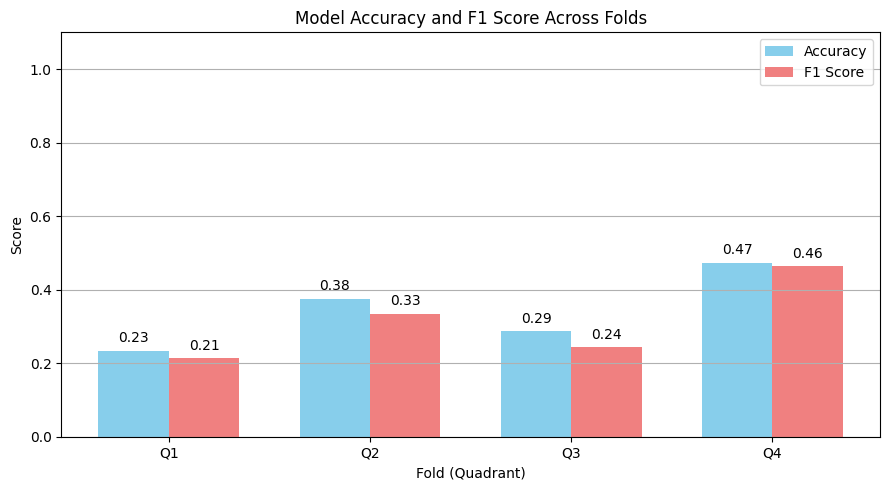

In [12]:
folds = ["Q1", "Q2", "Q3", "Q4"] 

x = np.arange(len(folds))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(9, 5))

rects1 = ax.bar(x - width/2, fold_accuracies, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, fold_f1_scores, width, label='F1 Score', color='lightcoral')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_xlabel('Fold (Quadrant)')
ax.set_title('Model Accuracy and F1 Score Across Folds')
ax.set_xticks(x)
ax.set_xticklabels(folds)
ax.set_ylim(0, 1.1)
ax.legend()

# Annotate each bar
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [13]:
# import cv2
# import pandas as pd
# from PIL import Image
# import matplotlib.patches as patches
# from tensorflow.keras.applications.vgg16 import preprocess_input
# import seaborn as sns

# Image.MAX_IMAGE_PIXELS = None

# # CONFIG
# IMAGE_SIZE = (224, 224)
# PATCH_SIZE = 224  # should match IMAGE_SIZE
# STRIDE = 224  # adjust stride for overlapping or non-overlapping
# CLASS_COLORS = {'Tumor': 0, 'Non-Tumor': 1, 'Empty': 2}
# COLOR_MAP = {0: 'blue', 1: 'green', 2: 'red'}

# # Load the big image
# big_img = Image.open('BigImage.tif').convert('RGB')
# big_arr = np.array(big_img)
# h, w, _ = big_arr.shape

# # model_input = preprocess_input  

# # Load best-performing model
# # folds = ["Q1", "Q2", "Q3", "Q4"]
# # best_fold = folds[np.argmax(fold_f1_scores)]
# best_fold = "Q1"
# best_model_path = f"vgg16_fold_{best_fold}.h5"
# model = tf.keras.models.load_model(best_model_path)
# print(f"Using best model from fold {best_fold}")

# # ---------------- HEATMAP INFERENCE ----------------
# heatmap = np.zeros((h // STRIDE, w // STRIDE), dtype=int)

# for i_idx, i in enumerate(range(0, h - PATCH_SIZE + 1, STRIDE)):
#     for j_idx, j in enumerate(range(0, w - PATCH_SIZE + 1, STRIDE)):
#         patch = big_arr[i:i+PATCH_SIZE, j:j+PATCH_SIZE]
#         patch_resized = cv2.resize(patch, IMAGE_SIZE).astype(np.float32)
#         patch_input = preprocess_input(np.expand_dims(patch_resized, axis=0))  # for VGG16
#         pred = model.predict(patch_input, verbose=0)
#         label = np.argmax(pred)
#         heatmap[i_idx, j_idx] = label

# # ---------------- PLOT HEATMAP ----------------
# plt.figure(figsize=(12, 10))
# sns.heatmap(heatmap, cmap='coolwarm', cbar_kws={'ticks': [0, 1, 2]},
#             xticklabels=False, yticklabels=False)
# plt.title(f'Prediction Heatmap using Fold {best_fold} Model')
# cbar = plt.gca().collections[0].colorbar
# cbar.set_ticklabels(CLASS_LABELS)
# plt.tight_layout()
# plt.show()


In [14]:
# import seaborn as sns
# plt.figure(figsize=(12, 10))
# sns.heatmap(heatmap, cmap='coolwarm', cbar_kws={'ticks': [0, 1, 2]},
#             xticklabels=False, yticklabels=False)
# plt.title(f'Prediction Heatmap using Fold {best_fold} Model')
# cbar = plt.gca().collections[0].colorbar
# cbar.set_ticklabels(cell_types)
# plt.tight_layout()
# plt.show()

In [15]:
# df = df_final
# tumor_coords = []

# for col in df.columns:
#     if 'x' in col:
#         y_col = col.replace('x', 'y')
#         xs = df[col].dropna()
#         ys = df[y_col].dropna()
#         tumor_coords.extend(zip(xs.astype(int), ys.astype(int)))

# # Build ground truth grid
# gt_map = np.zeros_like(heatmap)

# for x, y in tumor_coords:
#     if x < w and y < h:
#         i = y // STRIDE
#         j = x // STRIDE
#         if i < gt_map.shape[0] and j < gt_map.shape[1]:
#             gt_map[i, j] = 2  # mark as tumor

# # Plot heatmap with overlay
# plt.figure(figsize=(12, 10))
# sns.heatmap(heatmap, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar=False)
# plt.title('Prediction Heatmap with Ground Truth Overlay')

# # Overlay ground truth (tumor) cells
# for i in range(gt_map.shape[0]):
#     for j in range(gt_map.shape[1]):
#         if gt_map[i, j] == 2:
#             plt.gca().add_patch(patches.Rectangle((j, i), 1, 1, edgecolor='yellow', fill=False, linewidth=1))

# plt.show()